## Car Price Prediction – Modelltraining, Evaluation und Visualisierungen
#### Kalisch & Pfaffenlehner

#### This Notebook Code Includes:

1. **Load Data and Overview:**  
   - Reads the dataset and displays the first few rows.

2. **Mapping of Categorical Variables:**  
   - Converts values such as "Audi", "Petrol", etc. into numerical codes.

3. **Feature Engineering:**  
   - Calculates vehicle age based on the manufacturing year.  
   - Transforms "Mileage" using the square root and "Price" using a log-transformation.

4. **Data Preparation and Standardization:**  
   - Splits the dataset into training and testing sets and standardizes the features.

5. **Polynomial Expansion:**  
   - Expands the features by adding quadratic and cubic terms.

6. **Model Training and Evaluation (Log Scale):**  
   - Trains a Ridge Regression model, computing RMSE and R^2 in the log-transformed space.

7. **Visualizations and Detailed Explanations:**  
   - **Histograms:**  
     - Distribution of original prices and log-transformed prices.  
     - **Explanation:** Shows how skewed the price distribution is and how the log-transformation makes it more symmetric.
   - **Scatterplot (Log Scale):**  
     - Actual vs. predicted log(Price+1) values.  
     - **Explanation:** An ideal model would place all points along the diagonal.
   - **Histogram of Residuals (Log Scale):**  
     - Distribution of differences between actual and predicted log-values.
   - **Scatterplot (Original Scale):**  
     - Actual vs. predicted prices, back-transformed using expm1.  
     - **Explanation:** Illustrates the practical prediction error in Euros.
   - **Histogram of Residuals (Original Scale):**  
     - Shows the error distribution in the original scale.

8. **Saving the Model:**  
   - Saves the model parameters and standardization values in `ridge_model.json`.

Link: [https://mr-kittiecat.github.io/](https://mr-kittiecat.github.io/)

### Imports

In [47]:
import pandas as pd
import numpy as np
import json
import datetime
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score

### 1. Load Data and Overview

In [37]:
def load_data(file_path):
    """Loads the dataset and returns a DataFrame."""
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully.\n")
        return df
    except FileNotFoundError:
        sys.exit(f"Error: The file '{file_path}' was not found.")

data_file = "car_price_dataset.csv"
df = load_data(data_file)

print("First few rows of the dataset:")
print(df.head(), "\n")
print("Dataset columns:", df.columns.tolist(), "\n")

Dataset loaded successfully.

First few rows of the dataset:
        Brand   Model  Year  Engine_Size Fuel_Type    Transmission  Mileage  \
0         Kia     Rio  2020          4.2    Diesel          Manual   289944   
1   Chevrolet  Malibu  2012          2.0    Hybrid       Automatic     5356   
2    Mercedes     GLA  2020          4.2    Diesel       Automatic   231440   
3        Audi      Q5  2023          2.0  Electric          Manual   160971   
4  Volkswagen    Golf  2003          2.6    Hybrid  Semi-Automatic   286618   

   Doors  Owner_Count  Price  
0      3            5   8501  
1      2            3  12092  
2      4            2  11171  
3      2            1  11780  
4      3            3   2867   

Dataset columns: ['Brand', 'Model', 'Year', 'Engine_Size', 'Fuel_Type', 'Transmission', 'Mileage', 'Doors', 'Owner_Count', 'Price'] 



### 2. Mapping of Categorical Variables

We map the English categorical values to numerical codes:

- **Brand:** e.g., "Audi" -> 0, "BMW" -> 1, etc.
- **Fuel_Type:** "Petrol", "Diesel", "Electric", "Hybrid"
- **Transmission:** "Manual", "Automatic", "Semi-Automatic"

In [ ]:
def map_categories(df):
    """Converts categorical variables to numerical codes."""
    # Mapping for 'Brand'
    brand_mapping = {
        "Audi": 0,
        "BMW": 1,
        "Mercedes": 2,
        "Volkswagen": 3,
        "Toyota": 4,
        "Ford": 5,
        "Honda": 6,
        "Chevrolet": 7,
        "Kia": 8,
        "Hyundai": 9
    }
    # Mapping for 'Fuel_Type'
    fuel_mapping = {
        "Petrol": 0,
        "Diesel": 1,
        "Electric": 2,
        "Hybrid": 3
    }
    # Mapping for 'Transmission'
    transmission_mapping = {
        "Manual": 0,
        "Automatic": 1,
        "Semi-Automatic": 2
    }
    
    print("Unique Brand values before mapping:", df["Brand"].unique())
    print("Unique Fuel_Type values before mapping:", df["Fuel_Type"].unique())
    print("Unique Transmission values before mapping:", df["Transmission"].unique(), "\n")
    
    df['Brand'] = df['Brand'].map(brand_mapping)
    df['Fuel_Type'] = df['Fuel_Type'].map(fuel_mapping)
    df['Transmission'] = df['Transmission'].map(transmission_mapping)
    
    print("Unique Brand values after mapping:", df["Brand"].unique())
    print("Unique Fuel_Type values after mapping:", df["Fuel_Type"].unique())
    print("Unique Transmission values after mapping:", df["Transmission"].unique(), "\n")
    
    return df

df = map_categories(df)


Unique Brand values before mapping: ['Kia' 'Chevrolet' 'Mercedes' 'Audi' 'Volkswagen' 'Toyota' 'Honda' 'BMW'
 'Hyundai' 'Ford']
Unique Fuel_Type values before mapping: ['Diesel' 'Hybrid' 'Electric' 'Petrol']
Unique Transmission values before mapping: ['Manual' 'Automatic' 'Semi-Automatic'] 

Unique Brand values after mapping: [8 7 2 0 3 4 6 1 9 5]
Unique Fuel_Type values after mapping: [1 3 2 0]
Unique Transmission values after mapping: [0 1 2] 



### 3. Feature Engineering

- **Vehicle Age:** Calculated as the difference between the current year and the manufacturing year (`Year`).
- **Mileage:** Square root transformation to reduce the effect of extreme values.
- **Price:** Log-transformation (log1p) to achieve a more symmetric distribution.

The following histograms display the distribution of the original prices and the log-transformed prices.

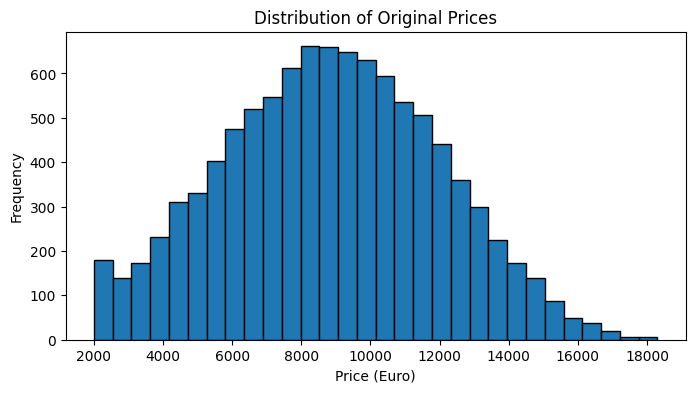

Explanation: This histogram shows the skewed distribution of car prices. A few high prices can distort the distribution.



In [41]:
def add_features(df):
    """Calculates additional features such as vehicle age."""
    current_year = datetime.datetime.now().year
    df['vehicle_age'] = current_year - df['Year']
    return df

df = add_features(df)

# Plot: Distribution of original prices
plt.figure(figsize=(8, 4))
plt.hist(df['Price'], bins=30, edgecolor='black')
plt.title("Distribution of Original Prices")
plt.xlabel("Price (Euro)")
plt.ylabel("Frequency")
plt.show()
print("Explanation: This histogram shows the skewed distribution of car prices. A few high prices can distort the distribution.\n")

- **What you see:** The histogram displays the frequency of car prices in the dataset, with most vehicles falling within a specific price range, but a long right tail is visible.
- **Interpretation:** The distribution is right-skewed, meaning that while most vehicles are priced in a moderate range, a few very high-priced vehicles distort the overall distribution. This skewness suggests that using the raw price values for regression might lead to issues and that a transformation (like a log transformation) could be beneficial.

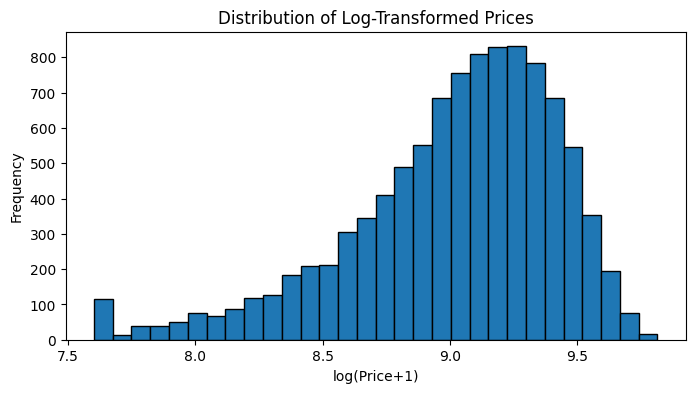

Explanation: The log-transformation makes the distribution more symmetric, which is beneficial for regression models.



In [42]:
# Plot: Distribution of log-transformed prices
prices_log = np.log1p(df['Price'])
plt.figure(figsize=(8, 4))
plt.hist(prices_log, bins=30, edgecolor='black')
plt.title("Distribution of Log-Transformed Prices")
plt.xlabel("log(Price+1)")
plt.ylabel("Frequency")
plt.show()
print("Explanation: The log-transformation makes the distribution more symmetric, which is beneficial for regression models.\n")

- **What you see:** The histogram of log-transformed prices (using log(Price+1)) shows a more symmetric, bell-shaped distribution.
- **Interpretation:** The log-transformation reduces the effect of extreme values (high prices) and makes the distribution more symmetric. This transformation typically improves the performance of regression models, as many models assume a more normally distributed target variable.

### 4.1. Data Preparation and Preprocessing

We select the relevant features, remove rows with missing values (e.g., due to mapping issues), and transform the mileage.

In [43]:
def preprocess_data(df, features, target):
    """Prepares the data, applies transformations, and removes invalid rows."""
    for col in features + [target]:
        if col not in df.columns:
            sys.exit(f"Error: Column '{col}' is missing from the dataset.")
    
    X = df[features].copy()
    y = df[target]
    
    print("Missing values in X before transformation:\n", X.isnull().sum(), "\n")
    print("Missing values in y before transformation:\n", y.isnull().sum(), "\n")
    
    df_clean = df.dropna(subset=features + [target])
    if df_clean.shape[0] == 0:
        sys.exit("Error: All rows were removed due to missing values. Please check the mapping and the dataset.")
    print(f"Rows remaining after removing missing values: {len(df_clean)}\n")
    
    X = df_clean[features].copy()
    y = df_clean[target]
    
    # Transform Mileage: square root (as used in the frontend)
    X['Mileage'] = np.sqrt(X['Mileage'])
    
    # Log-transform the target variable (Price)
    y_log = np.log1p(y)
    
    return X, y_log

features = ['Brand', 'Engine_Size', 'Mileage', 'vehicle_age', 'Fuel_Type', 'Transmission', 'Doors']
target = 'Price'
X, y_log = preprocess_data(df, features, target)

Missing values in X before transformation:
 Brand           0
Engine_Size     0
Mileage         0
vehicle_age     0
Fuel_Type       0
Transmission    0
Doors           0
dtype: int64 

Missing values in y before transformation:
 0 

Rows remaining after removing missing values: 10000



### 4.2. Splitting the Data and Standardization

We split the dataset into training and testing sets (80/20) and standardize the features.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape, "Testing data shape:", X_test.shape, "\n")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape, "\n")


Training data shape: (8000, 7) Testing data shape: (2000, 7) 

Shape of X_train_scaled: (8000, 7)
Shape of X_test_scaled: (2000, 7) 



### 5. Polynomial Expansion

Since the frontend also uses polynomial features, we expand the standardized features by their squares and cubes (without interaction terms):

$$ X_{poly} = [X, X^2, X^3] $$

In [45]:
def polynomial_expansion(X_scaled):
    """Creates linear, quadratic, and cubic features (without cross-terms)."""
    return np.concatenate([X_scaled, X_scaled**2, X_scaled**3], axis=1)

X_train_poly = polynomial_expansion(X_train_scaled)
X_test_poly = polynomial_expansion(X_test_scaled)

print("Shape of X_train_poly:", X_train_poly.shape)
print("Shape of X_test_poly:", X_test_poly.shape, "\n")

Shape of X_train_poly: (8000, 21)
Shape of X_test_poly: (2000, 21) 



### 6. Model Training and Evaluation (Log Scale)

We train a Ridge Regression model and evaluate it using:
- **RMSE** (Root Mean Squared Error)
- **R^2 Score** (Coefficient of Determination)

These metrics are computed in the log-transformed space.

In [49]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)

y_pred = ridge.predict(X_test_poly)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE (log scale): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


RMSE (log scale): 0.09
R^2 Score: 0.95


### 7. Visualizations in the Log Scale

**Scatterplot (Log Scale):**  
Plots the actual vs. predicted log(Price+1) values.  
**Explanation:** Points close to the diagonal indicate accurate predictions.

**Histogram of Residuals (Log Scale):**  
Shows the distribution of prediction errors in the log scale.

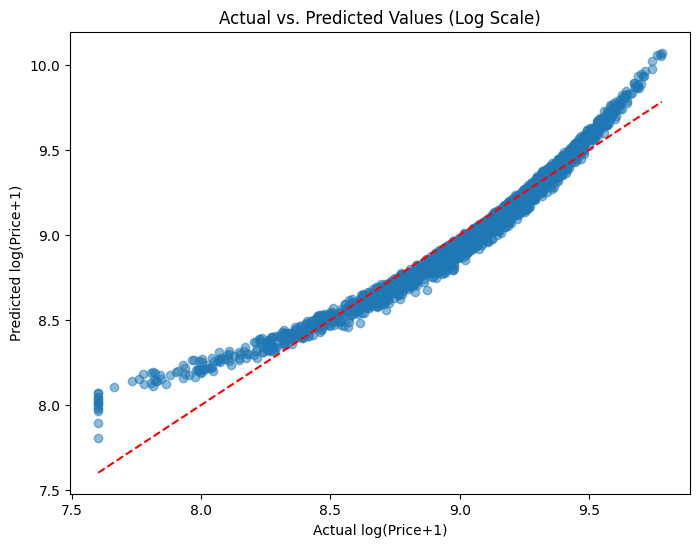

Explanation: Points along the red diagonal indicate that predictions match the actual log-values closely.



In [50]:
# Scatterplot: Actual vs. Predicted (Log Scale)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual log(Price+1)")
plt.ylabel("Predicted log(Price+1)")
plt.title("Actual vs. Predicted Values (Log Scale)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
print("Explanation: Points along the red diagonal indicate that predictions match the actual log-values closely.\n")

- **What you see:** A scatterplot where the x-axis represents the actual log(Price+1) values and the y-axis represents the predicted log(Price+1) values. A red dashed line indicates the ideal scenario where predictions match actual values.
- **Interpretation:** Points that lie close to the red diagonal indicate that the model's predictions are very close to the actual values in the log-transformed space. A tight clustering around this diagonal reflects high accuracy of the model when evaluated on the log scale.

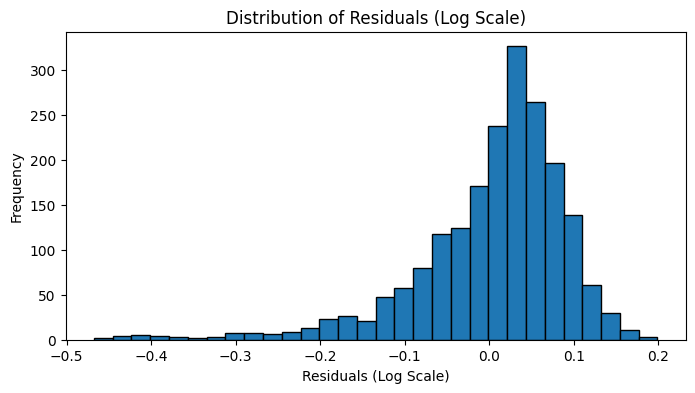

Explanation: A symmetric distribution of residuals centered around 0 indicates a well-calibrated model in log scale.



In [51]:
# Histogram of Residuals (Log Scale)
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel("Residuals (Log Scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Log Scale)")
plt.show()
print("Explanation: A symmetric distribution of residuals centered around 0 indicates a well-calibrated model in log scale.\n")

- **What you see:** The histogram shows the frequency distribution of residuals (the differences between the actual and predicted log(Price+1) values).
- **Interpretation:** A symmetric distribution of residuals centered around zero indicates that the model does not have a systematic bias. This symmetry and the small spread of residuals imply that the predictions are generally close to the true values in the log space.

### 8. Evaluation in the Original Scale

To better understand the practical performance of the model, we transform the predictions back to the original scale.

**Calculation:**  
- Back-transform the predictions and actual values using `np.expm1`.  
- Compute RMSE in the original scale.

**Visualizations:**  
- **Scatterplot:** Actual vs. predicted prices (in Euros).  
- **Histogram of Residuals:** Shows the error distribution in the original scale.

In [53]:
# Back-transform log-values to original scale
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)

rmse_orig = root_mean_squared_error(y_test_orig, y_pred_orig)
print(f"RMSE (Original Scale): {rmse_orig:.2f}")
print("Explanation: The RMSE in the original scale indicates the average error in Euros.\n")

RMSE (Original Scale): 828.73
Explanation: The RMSE in the original scale indicates the average error in Euros.



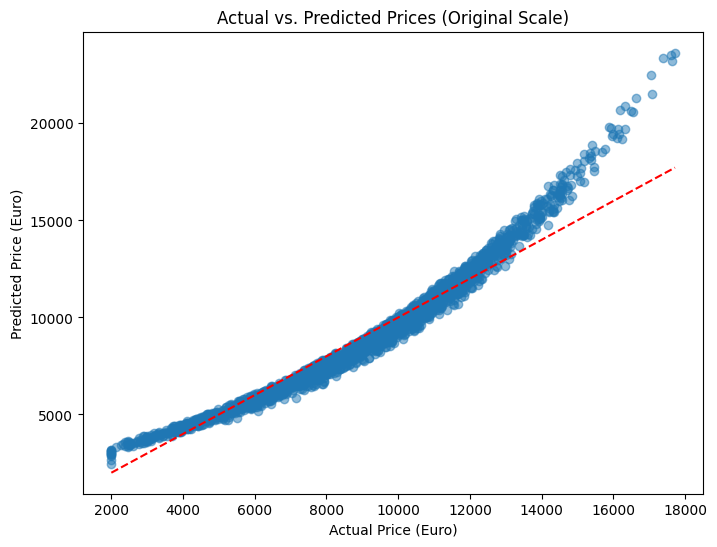

Explanation: Points near the red line indicate accurate predictions in the original scale.



In [54]:
# Scatterplot: Actual vs. Predicted Prices (Original Scale)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.xlabel("Actual Price (Euro)")
plt.ylabel("Predicted Price (Euro)")
plt.title("Actual vs. Predicted Prices (Original Scale)")
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.show()
print("Explanation: Points near the red line indicate accurate predictions in the original scale.\n")

- **What you see:** This scatterplot shows the actual car prices against the predicted car prices, after back-transforming the log values using `expm1`. A red dashed line represents perfect predictions.
- **Interpretation:** Points near the red line indicate that the predicted prices are close to the actual prices. While there may be some spread (especially at higher price ranges), the overall clustering near the line suggests that the model performs well in practical, real-world terms (i.e., in Euros).

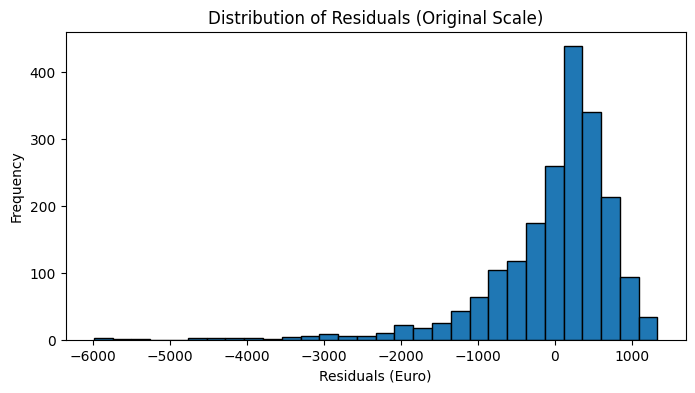

Explanation: This histogram shows how much the predicted prices deviate from the actual prices in Euros.



In [55]:
# Histogram of Residuals (Original Scale)
residuals_orig = y_test_orig - y_pred_orig
plt.figure(figsize=(8, 4))
plt.hist(residuals_orig, bins=30, edgecolor='black')
plt.xlabel("Residuals (Euro)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Original Scale)")
plt.show()
print("Explanation: This histogram shows how much the predicted prices deviate from the actual prices in Euros.\n")

   - **What you see:** The histogram displays the distribution of the differences (residuals) between the actual prices and the predicted prices in the original scale.
   - **Interpretation:** Most residuals are concentrated around zero, indicating that on average the model’s predictions deviate only slightly from the actual prices. A few outliers may exist, but overall, the error distribution demonstrates that the model is quite accurate in predicting car prices in Euros.

### 9. Saving the Model

We save the model intercept, coefficients, and the standardization parameters in a JSON file (`ridge_model.json`).
This file can then be used in the frontend for making predictions.

In [58]:
ridge_model = {
    "ridge_intercept": float(ridge.intercept_),
    "ridge_coefficients": ridge.coef_.tolist(),
    "scaler_mean": scaler.mean_.tolist(),
    "scaler_scale": scaler.scale_.tolist()
}

with open("ridge_model.json", "w") as f:
    json.dump(ridge_model, f)

print("\n✅ Model successfully saved as 'ridge_model.json'")


✅ Model successfully saved as 'ridge_model.json'
